In [4]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, random_split
import gc
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

trained_model_path = "./trained_models/ResNet-v3.pth"
dataset_path = "./datasets/Prostate Cancer"

SEED = 42


cuda


In [5]:
def data_loader(data_path, batch_size,shuffle=True):
    normalize = transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],std=[0.2023, 0.1994, 0.2010])

    # define transforms
    transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            normalize,
    ])

    dataset = datasets.ImageFolder(data_path, transform=transform)

    test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    
    return test_loader

test_loader = data_loader(data_path=dataset_path, batch_size=64)

In [6]:
from itertools import product


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()

        # convolutional layers
        self.convolution_layer_1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.convolution_layer_2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))

        self.downsample = downsample
        
        # activation function
        self.relu = nn.ReLU()

        # numebr of output layers
        self.out_channels = out_channels

    def forward(self, x):
        residual = x

        output = self.convolution_layer_1(x)
        output = self.convolution_layer_2(output)

        if self.downsample:
            residual = self.downsample(x)

        output += residual
        output = self.relu(output)

        return output
    
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super(ResNet, self).__init__()
        self.inplanes = 64

        self.convolutional_layer_1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.max_pooling = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)

        self.layer0 = self._generate_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._generate_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._generate_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._generate_layer(block, 512, layers[3], stride = 2)

        self.average_pooling = nn.AvgPool2d(7, stride=1)

        self.fully_connected = nn.Linear(512, num_classes)

    def _generate_layer(self, block, planes, blocks, stride=1):
        downsample = None

        # downsample when the width/height of the output is smaller than the input or the stride is > 1
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
            
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.convolutional_layer_1(x)
        x = self.max_pooling(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.average_pooling(x)
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)

        return x

model = ResNet(ResidualBlock, [2, 4, 6, 3]).to(device)
model.load_state_dict(torch.load(trained_model_path))
model.eval()

C:\Users\kazad\AppData\Local\Temp\ipykernel_22564\4125431430.py:94: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(trained_model_path))


ResNet(
  (convolutional_layer_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (max_pooling): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (convolution_layer_1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (convolution_layer_2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
    (1): ResidualBlock(
      (convolution_layer_1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

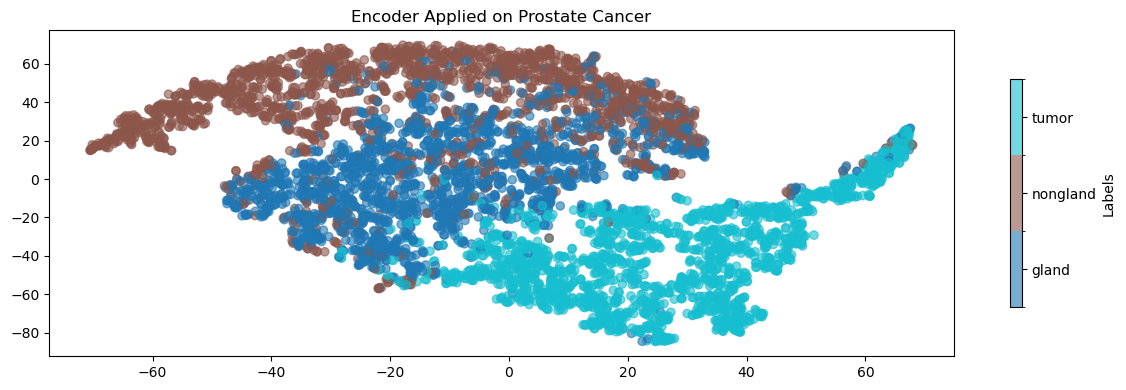

In [8]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
import matplotlib.colors as mcolors

# feature extractor
class FeatureExtractor(nn.Module):
    def __init__(self, original_model):
        super(FeatureExtractor, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-1])
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return x

feature_extractor = FeatureExtractor(model).to(device)
feature_extractor.eval()

# Collect preencoded and encoded features
encoded_features = []
labels_list = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        
        preencoded = images.view(images.size(0), -1).cpu().numpy()
        
        encoded = feature_extractor(images).cpu().numpy()
        encoded_features.append(encoded)
        
        labels_list.append(labels.numpy())
        
        del images, encoded
        torch.cuda.empty_cache()

# Concatenate features and labels
encoded_features = np.concatenate(encoded_features)
labels_list = np.concatenate(labels_list)

tsne_2d = TSNE(n_components=2, random_state=42)
tsne_3d = TSNE(n_components=3, random_state=42)

encoded_tsne_2d = tsne_2d.fit_transform(encoded_features)
encoded_tsne_3d = tsne_3d.fit_transform(encoded_features)
label_tags=["gland", "nongland", "tumor"]

fig, axes = plt.subplots(figsize=(12, 4))

# Define a discrete colormap with boundaries based on unique labels
unique_labels = np.unique(labels)
cmap = plt.get_cmap('tab10', len(unique_labels))
norm = mcolors.BoundaryNorm(boundaries=np.arange(len(unique_labels) + 1) - 0.5, ncolors=len(unique_labels))

scatter1 = axes.scatter(encoded_tsne_2d[:, 0], encoded_tsne_2d[:, 1], c=labels_list, cmap=cmap, norm=norm, alpha=0.6)
axes.set_title(f'Encoder Applied on Prostate Cancer')
cbar1 = fig.colorbar(scatter1, ax=axes, shrink=0.7, ticks=unique_labels)
cbar1.set_label('Labels')
cbar1.set_ticks(unique_labels)
cbar1.set_ticklabels(label_tags)


# scatter2 = axes[1].scatter(encoded_tsne_3d[:, 0], encoded_tsne_3d[:, 1], c=labels_list, cmap=cmap, norm=norm, alpha=0.6)
# axes[1].set_title(f'Encoded Features - 3D')
# cbar2 = fig.colorbar(scatter2, ax=axes[1], shrink=0.7, ticks=unique_labels)
# cbar2.set_label('Labels')
# cbar2.set_ticks(unique_labels)
# cbar2.set_ticklabels(label_tags)


plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.tight_layout()
plt.show()